In [1]:
# importovanje biblioteka koje ce nam biti potrebne kasnije
import numpy as np
import pandas as pd 
import time
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import model_selection
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

In [2]:
#Ucitavanje fajla sa podacima za trening
data= pd.read_csv('D:\\Vlada\\Milica master\\german_credit_data.csv')
di = {"good": 0, "bad": 1}
data.replace({"Risk": di}, inplace=True)
data.rename(columns ={"Risk": "TARGET"}, inplace = True)
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
print('Dimenzije trening skupa: ', X_train.shape)
X_train.head()

Dimenzije trening skupa:  (800, 10)


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
828,828,47,male,2,free,NaN,little,8335,36,car
997,997,38,male,2,own,little,NaN,804,12,radio/TV
148,148,28,male,2,own,little,little,5371,36,furniture/equipment
735,735,29,female,0,own,NaN,moderate,3990,36,domestic appliances
130,130,24,female,2,own,NaN,moderate,8487,48,car


In [3]:
y_train

828    1
997    0
148    0
735    0
130    0
      ..
492    0
545    1
298    0
417    0
749    0
Name: TARGET, Length: 800, dtype: int64

In [4]:
#izracunavanje woe vrednosti
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [5]:
X_train = X_train.drop('Unnamed: 0', axis = 1)

In [6]:
final_iv, IV = data_vars(X_train,y_train)

In [7]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,Age,19,33,415,140,0.337349,275,0.662651,0.583333,0.491071,0.172169,0.034339
1,Age,34,75,385,100,0.259740,285,0.740260,0.416667,0.508929,-0.200021,0.034339
2,Sex,female,female,249,89,0.357430,160,0.642570,0.370833,0.285714,0.260760,0.032996
3,Sex,male,male,551,151,0.274047,400,0.725953,0.629167,0.714286,-0.126887,0.032996
4,Job,0,2,685,200,0.291971,485,0.708029,0.833333,0.866071,-0.038534,0.008421
5,Job,3,3,115,40,0.347826,75,0.652174,0.166667,0.133929,0.218689,0.008421
6,Housing,free,free,86,35,0.406977,51,0.593023,0.145833,0.091071,0.470820,0.088097
7,Housing,own,own,570,148,0.259649,422,0.740351,0.616667,0.753571,-0.200495,0.088097
8,Housing,rent,rent,144,57,0.395833,87,0.604167,0.237500,0.155357,0.424441,0.088097
9,Saving accounts,little,little,475,173,0.364211,302,0.635789,0.720833,0.539286,0.290162,0.225283


In [8]:
final_iv.to_csv("final_iv2.csv",index = False, chunksize = 500)

In [9]:
#Varijable koje imaju informativnu vrednost iznad 0.1
IV.loc[IV['IV']>0.1]

,VAR_NAME,IV
1,Checking account,0.616798
3,Duration,0.210183
7,Saving accounts,0.225283


In [10]:
X_train.head(4)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
828,47,male,2,free,NaN,little,8335,36,car
997,38,male,2,own,little,NaN,804,12,radio/TV
148,28,male,2,own,little,little,5371,36,furniture/equipment
735,29,female,0,own,NaN,moderate,3990,36,domestic appliances


In [11]:
final_iv.head(10)

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,Age,19,33,415,140,0.337349,275,0.662651,0.583333,0.491071,0.172169,0.034339
1,Age,34,75,385,100,0.259740,285,0.740260,0.416667,0.508929,-0.200021,0.034339
2,Sex,female,female,249,89,0.357430,160,0.642570,0.370833,0.285714,0.260760,0.032996
3,Sex,male,male,551,151,0.274047,400,0.725953,0.629167,0.714286,-0.126887,0.032996
4,Job,0,2,685,200,0.291971,485,0.708029,0.833333,0.866071,-0.038534,0.008421
5,Job,3,3,115,40,0.347826,75,0.652174,0.166667,0.133929,0.218689,0.008421
6,Housing,free,free,86,35,0.406977,51,0.593023,0.145833,0.091071,0.470820,0.088097
7,Housing,own,own,570,148,0.259649,422,0.740351,0.616667,0.753571,-0.200495,0.088097
8,Housing,rent,rent,144,57,0.395833,87,0.604167,0.237500,0.155357,0.424441,0.088097
9,Saving accounts,little,little,475,173,0.364211,302,0.635789,0.720833,0.539286,0.290162,0.225283


In [13]:
import time

#transformisemo pocetni uzorak tako sto umesto pocetne vrednosti varijable, stavljamo njenu WOE vrednost
def WOE_transformation(data,vars):
    start = time.time()

    for var in vars:

        tmp = final_iv[final_iv['VAR_NAME']==var][['MIN_VALUE','MAX_VALUE','WOE']]

        for idx, row in data.iterrows():

            for l,r,w in zip(tmp['MIN_VALUE'],tmp['MAX_VALUE'], tmp['WOE']):

                if (isinstance(row[var], numbers.Number) and  isinstance(l, numbers.Number)):
                    if (row[var]>=l and row[var]<=r): 
                        data.loc[idx, var] = w
                    
                elif (isinstance(row[var], str) and  isinstance(l, str) and l==row[var]) or (pd.isna(row[var])):
                    data.loc[idx, var] = w

    end = time.time()
    print(round((end-start)/60,2))

In [23]:
vars=['Checking account','Duration','Saving accounts']
WOE_transformation(X_train,vars)
WOE_transformation(X_test,vars)

0.01
0.0


In [24]:
X_train

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
828,47,male,2,free,-1.12678,0.76506,8335,0.448950,car
997,38,male,2,own,0.290162,-0.225339,804,-0.198671,radio/TV
148,28,male,2,own,0.290162,0.76506,5371,0.448950,furniture/equipment
735,29,female,0,own,-1.12678,0.41058,3990,0.448950,domestic appliances
130,24,female,2,own,-1.12678,0.41058,8487,0.754925,car
...,...,...,...,...,...,...,...,...,...
492,27,female,2,own,0.154151,-0.225339,1237,-0.927654,radio/TV
545,43,male,2,free,0.290162,0.76506,1333,0.070068,car
298,43,male,2,own,0.290162,-0.225339,2515,0.041210,furniture/equipment
417,23,female,2,rent,-1.12678,0.76506,8471,0.041210,education


In [25]:
#WOE transformacija traje dugo pa cemo rezultate sacuvati u excelu
X_test_short_list=X_test[['Checking account','Duration','Saving accounts']]
X_train_short_list=X_train[['Checking account','Duration','Saving accounts']]

In [26]:
X_train_short_list.to_csv('X_train_short_list2.csv',index = False, chunksize = 500)

In [27]:
X_test_short_list.to_csv('X_test_short_list2.csv',index = False, chunksize = 500)

In [28]:
X_train_short_list=pd.read_csv('D:\\Vlada\\Milica master\\X_train_short_list2.csv')
X_test_short_list=pd.read_csv('D:\\Vlada\\Milica master\\X_test_short_list2.csv')

In [29]:
X_train_short_list

,Checking account,Duration,Saving accounts
0,0.765060,0.448950,-1.126783
1,-0.225339,-0.198671,0.290162
2,0.765060,0.448950,0.290162
3,0.410580,0.448950,-1.126783
4,0.410580,0.754925,-1.126783
...,...,...,...
795,-0.225339,-0.927654,0.154151
796,0.765060,0.070068,0.290162
797,-0.225339,0.041210,0.290162
798,0.765060,0.041210,-1.126783


In [30]:
grid_model = LogisticRegression()
params = {'C': [10**i for i in range(-5, 5)]}
grid = model_selection.GridSearchCV(grid_model, param_grid=params, scoring='roc_auc', cv=5, return_train_score=True)

In [31]:
grid.fit(X_train_short_list, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000]},
             return_train_score=True, scoring='roc_auc')

In [32]:
grid.best_params_

{'C': 10}

In [33]:
log_reg = LogisticRegression(class_weight = 'balanced',C = 10)
#Obucavamo model na trening setu
log_reg.fit(X_train_short_list, y_train)

LogisticRegression(C=10, class_weight='balanced')

In [34]:
log_reg_pred = log_reg.predict_proba(X_test_short_list)
log_reg_pred

array([[0.60412335, 0.39587665],
       [0.442577  , 0.557423  ],
       [0.25763731, 0.74236269],
       [0.26307155, 0.73692845],
       [0.45660859, 0.54339141],
       [0.38573017, 0.61426983],
       [0.38573017, 0.61426983],
       [0.64735847, 0.35264153],
       [0.38573017, 0.61426983],
       [0.65864507, 0.34135493],
       [0.69828915, 0.30171085],
       [0.31099354, 0.68900646],
       [0.81688008, 0.18311992],
       [0.53721381, 0.46278619],
       [0.26307155, 0.73692845],
       [0.81688008, 0.18311992],
       [0.38573017, 0.61426983],
       [0.70426552, 0.29573448],
       [0.53721381, 0.46278619],
       [0.84163307, 0.15836693],
       [0.80339074, 0.19660926],
       [0.53721381, 0.46278619],
       [0.68620953, 0.31379047],
       [0.25763731, 0.74236269],
       [0.38573017, 0.61426983],
       [0.38573017, 0.61426983],
       [0.91554673, 0.08445327],
       [0.81688008, 0.18311992],
       [0.62706614, 0.37293386],
       [0.68620953, 0.31379047],
       [0.

In [35]:
print("Tacnost na trening setu: {:.3f}".format(log_reg.score(X_train_short_list, y_train)))
print("Tacnost na test setu: {:.3f}".format(log_reg.score(X_test_short_list, y_test)))

Tacnost na trening setu: 0.688
Tacnost na test setu: 0.725


In [36]:
predicted = log_reg.predict(X_test_short_list)
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       140
           1       0.53      0.75      0.62        60

    accuracy                           0.73       200
   macro avg       0.70      0.73      0.70       200
weighted avg       0.77      0.72      0.74       200



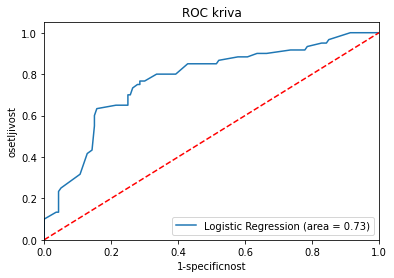

In [37]:
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test_short_list))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test_short_list)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-specificnost')
plt.ylabel('osetljivost')
plt.title('ROC kriva')
plt.legend(loc="lower right")
plt.show()
plt.show()